# CS 412 Project

# 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import analysis

In [2]:
conditions = pd.read_csv("conditions.csv")
patients = pd.read_csv("patients.csv")
observations = pd.read_csv("observations.csv")
care_plans = pd.read_csv("careplans.csv")
encounters = pd.read_csv("encounters.csv")
devices = pd.read_csv("devices.csv")
supplies = pd.read_csv('supplies.csv')
procedures = pd.read_csv("procedures.csv")
medications = pd.read_csv("medications.csv")

### IDs of patients that have been diagnosed with COVID-19

In [3]:
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()

### IDs for all patients that died in the simulation

In [4]:
deceased_patients = patients[patients.DEATHDATE.notna()].Id

### IDs for patients with admission due to COVID-19

In [5]:
inpatient_ids = encounters[(encounters.REASONCODE == 840539006) & (encounters.CODE == 1505002)].PATIENT

###  IDs for patients that have completed the care plan for isolation at home

In [6]:
completed_isolation_patients = care_plans[(care_plans.CODE == 736376001) & (care_plans.STOP.notna()) & (care_plans.REASONCODE == 840539006)].PATIENT

### every patient with a negative SARS-CoV-2 test

In [7]:
negative_covid_patient_ids = observations[(observations.CODE == '94531-1') & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()

### Survivors(the union of those who have completed isolation at home or have a negative SARS-CoV-2 test)

In [8]:
survivor_ids = np.union1d(completed_isolation_patients, negative_covid_patient_ids)

### COVID-19 conditions out of all conditions in the simulation

In [9]:
covid_conditions = conditions[conditions.CODE == 840539006]

### new DataFrame with boolean columns representing various outcomes, like admit, recovery or death

In [10]:
cp = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')
isolation_ids = care_plans[(care_plans.CODE == 736376001) & (care_plans.REASONCODE == 840539006)].PATIENT
cp['isolation'] = cp.Id.isin(isolation_ids)
cp['admit'] = cp.Id.isin(inpatient_ids)
cp['recovered'] = cp.Id.isin(survivor_ids)
cp['death'] = cp.DEATHDATE.notna()
icu_ids = encounters[encounters.CODE == 305351004].PATIENT
cp['icu_admit'] = cp.Id.isin(icu_ids)
vent_ids = procedures[procedures.CODE == 26763009].PATIENT
cp['ventilated'] = cp.Id.isin(vent_ids)

In [11]:
covid_info = cp[['PATIENT', 'recovered', 'death', 'START', 'DEATHDATE', 'BIRTHDATE', 'GENDER', 'admit', 'icu_admit']]

In [12]:
covid_info = covid_info.rename(columns={'START': 'covid_start'})

In [13]:
covid_related_conditions = conditions[pd.to_datetime(conditions.START) > pd.to_datetime('2020-01-20')]

### all conditions for COVID-19 patients

In [14]:
covid_patient_conditions = covid_info.merge(covid_related_conditions, on='PATIENT')

# 2. Preparing Data for Machine Learning

In [15]:
X = patients[patients['Id'].isin(covid_patient_ids)]

In [16]:
X = X[["Id","BIRTHDATE", "DEATHDATE", "RACE", "GENDER"]]

In [17]:
X

,Id,BIRTHDATE,DEATHDATE,RACE,GENDER
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,2017-08-24,NaN,white,M
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,2016-08-01,NaN,white,F
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,2004-01-09,NaN,white,F
3,cc3c806f-4a09-4a89-a990-4286450956be,1996-11-15,NaN,white,M
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,2019-06-12,NaN,white,F
...,...,...,...,...,...
124140,12d4e7cc-e86b-46c5-a696-ecd52b929b71,1948-06-03,NaN,white,M
124141,2dbac353-17bb-42da-9aa0-a302f052d1a3,1941-10-07,NaN,white,F
124146,8cf835a7-f161-4fe9-a559-350c97a3450e,1944-09-15,NaN,white,M
124147,503d768f-481c-46e2-bcdb-a6116686351a,1934-12-26,2020-03-18,white,M


#### Calculate AGE

In [18]:
def calculate_age(row):
    birthdate = row['BIRTHDATE']
    deathdate = row['DEATHDATE']
    # Use January 1st, 2020 as the reference date if DEATHDATE is NaN
    reference_date = pd.to_datetime('2020-01-01')
    if pd.isna(deathdate):
        age = reference_date.year - birthdate.year - ((reference_date.month, reference_date.day) < (birthdate.month, birthdate.day))
    else:
        age = deathdate.year - birthdate.year - ((deathdate.month, deathdate.day) < (birthdate.month, birthdate.day))
        
    if age < 30:
        age = "under30"
    elif age < 60 and age >= 30:
        age = "30-60"
    else:
        age = "over60"
    return age

In [19]:
X['BIRTHDATE'] = pd.to_datetime(X['BIRTHDATE'])
X['DEATHDATE'] = pd.to_datetime(X['DEATHDATE'])

In [20]:
X['AGE'] = X.apply(calculate_age, axis=1)
X = X[["Id","AGE","RACE","GENDER"]]
X = pd.get_dummies(X, columns=["AGE"])

In [21]:
X

,Id,RACE,GENDER,AGE_30-60,AGE_over60,AGE_under30
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,white,M,False,False,True
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,white,F,False,False,True
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,white,F,False,False,True
3,cc3c806f-4a09-4a89-a990-4286450956be,white,M,False,False,True
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,white,F,False,False,True
...,...,...,...,...,...,...
124140,12d4e7cc-e86b-46c5-a696-ecd52b929b71,white,M,False,True,False
124141,2dbac353-17bb-42da-9aa0-a302f052d1a3,white,F,False,True,False
124146,8cf835a7-f161-4fe9-a559-350c97a3450e,white,M,False,True,False
124147,503d768f-481c-46e2-bcdb-a6116686351a,white,M,False,True,False


#### One-hot encoding for RACE, GENDER

In [22]:
X = pd.get_dummies(X, columns=['RACE'])

In [23]:
X = pd.get_dummies(X, columns=['GENDER'])

In [24]:
X

,Id,AGE_30-60,AGE_over60,AGE_under30,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,GENDER_F,GENDER_M
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,False,False,True,False,False,False,False,True,False,True
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,False,False,True,False,False,False,False,True,True,False
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,False,False,True,False,False,False,False,True,True,False
3,cc3c806f-4a09-4a89-a990-4286450956be,False,False,True,False,False,False,False,True,False,True
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,False,False,True,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
124140,12d4e7cc-e86b-46c5-a696-ecd52b929b71,False,True,False,False,False,False,False,True,False,True
124141,2dbac353-17bb-42da-9aa0-a302f052d1a3,False,True,False,False,False,False,False,True,True,False
124146,8cf835a7-f161-4fe9-a559-350c97a3450e,False,True,False,False,False,False,False,True,False,True
124147,503d768f-481c-46e2-bcdb-a6116686351a,False,True,False,False,False,False,False,True,False,True


#### SYMPTOMS

#### sample table about symptoms by patients

In [25]:
covid_patient_conditions_description = covid_patient_conditions[["PATIENT", "DESCRIPTION"]]

In [26]:
sample = covid_patient_conditions_description.pivot_table(index='PATIENT', columns='DESCRIPTION', aggfunc=len, fill_value=0)

In [27]:
sample

DESCRIPTION,Acquired coagulation disorder (disorder),Acute Cholecystitis,Acute allergic reaction,Acute bacterial sinusitis (disorder),Acute bronchitis (disorder),Acute deep venous thrombosis (disorder),Acute pulmonary embolism (disorder),Acute respiratory distress syndrome (disorder),Acute respiratory failure (disorder),Acute viral pharyngitis (disorder),...,Stroke,Suspected COVID-19,Suspected lung cancer (situation),Tear of meniscus of knee,Third degree burn,Tubal pregnancy,Viral sinusitis (disorder),Vomiting symptom (finding),Wheezing (finding),Whiplash injury to neck
PATIENT,,,,,,,,,,,,,,,,,,,,,
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
0001054e-77c4-4e09-8310-7e5b1a579d8a,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
00019dce-e502-4272-82d2-d1c280f74150,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
0002760d-9404-43cb-873f-26b0a59d3a55,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
00034773-ca66-4191-8f43-56a9c20f8abf,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffd108b-0ae3-4894-88ee-1de037fea1d2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
fffde06d-4cf8-462a-9429-b3946224c517,1,0,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0
ffff5261-51f3-437c-9f5e-8cf237b26637,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
columns_to_keep = [col for col in sample.columns if "finding" in col]
sample_filtered = sample[columns_to_keep]

In [29]:
sample_filtered

DESCRIPTION,Body mass index 30+ - obesity (finding),Body mass index 40+ - severely obese (finding),Chill (finding),Cough (finding),Diarrhea symptom (finding),Dyspnea (finding),Fatigue (finding),Fever (finding),Headache (finding),Hemoptysis (finding),...,Loss of taste (finding),Muscle pain (finding),Nasal congestion (finding),Nausea (finding),Passive conjunctival congestion (finding),Respiratory distress (finding),Sore throat symptom (finding),Sputum finding (finding),Vomiting symptom (finding),Wheezing (finding)
PATIENT,,,,,,,,,,,,,,,,,,,,,
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,1,1,0,1,1,0,...,1,0,0,0,0,1,0,0,0,1
0001054e-77c4-4e09-8310-7e5b1a579d8a,0,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,1,1,0
00019dce-e502-4272-82d2-d1c280f74150,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
0002760d-9404-43cb-873f-26b0a59d3a55,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
00034773-ca66-4191-8f43-56a9c20f8abf,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffd108b-0ae3-4894-88ee-1de037fea1d2,0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,1,1,0,0
fffde06d-4cf8-462a-9429-b3946224c517,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
ffff5261-51f3-437c-9f5e-8cf237b26637,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
X.set_index('Id', inplace=True)

In [31]:
merged_df = X.merge(sample_filtered, left_index=True, right_index=True)

In [32]:
merged_df

,AGE_30-60,AGE_over60,AGE_under30,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,GENDER_F,GENDER_M,...,Loss of taste (finding),Muscle pain (finding),Nasal congestion (finding),Nausea (finding),Passive conjunctival congestion (finding),Respiratory distress (finding),Sore throat symptom (finding),Sputum finding (finding),Vomiting symptom (finding),Wheezing (finding)
1ff7f10f-a204-4bb1-aa72-dd763fa99482,False,False,True,False,False,False,False,True,False,True,...,0,0,0,0,0,0,0,0,0,0
9bcf6ed5-d808-44af-98a0-7d78a29ede72,False,False,True,False,False,False,False,True,True,False,...,0,0,0,0,0,0,0,1,0,0
5163c501-353c-4a82-b863-a3f1df2d6cf1,False,False,True,False,False,False,False,True,True,False,...,1,0,0,0,0,0,0,1,0,0
cc3c806f-4a09-4a89-a990-4286450956be,False,False,True,False,False,False,False,True,False,True,...,0,0,0,0,0,0,0,0,0,0
bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,False,False,True,False,False,False,False,True,True,False,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12d4e7cc-e86b-46c5-a696-ecd52b929b71,False,True,False,False,False,False,False,True,False,True,...,0,0,0,1,0,1,0,0,1,0
2dbac353-17bb-42da-9aa0-a302f052d1a3,False,True,False,False,False,False,False,True,True,False,...,1,0,0,0,0,0,0,0,0,0
8cf835a7-f161-4fe9-a559-350c97a3450e,False,True,False,False,False,False,False,True,False,True,...,0,0,0,0,0,0,0,0,0,1
503d768f-481c-46e2-bcdb-a6116686351a,False,True,False,False,False,False,False,True,False,True,...,1,1,0,0,0,1,0,1,0,0


#### ICU admitted (TRUE = 1, FALSE = 0)

In [33]:
covid_patient_conditions.set_index('PATIENT', inplace=True)

In [34]:
covid_patient_conditions_ICU = covid_patient_conditions[["icu_admit"]]

In [35]:
X = merged_df.merge(covid_patient_conditions_ICU, left_index=True, right_index=True)

In [36]:
X

,AGE_30-60,AGE_over60,AGE_under30,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,GENDER_F,GENDER_M,...,Muscle pain (finding),Nasal congestion (finding),Nausea (finding),Passive conjunctival congestion (finding),Respiratory distress (finding),Sore throat symptom (finding),Sputum finding (finding),Vomiting symptom (finding),Wheezing (finding),icu_admit
0001049f-9248-47fe-b479-ea80eb51ce4a,False,True,False,False,False,False,False,True,True,False,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,False,True,False,False,False,False,False,True,True,False,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,False,True,False,False,False,False,False,True,True,False,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,False,True,False,False,False,False,False,True,True,False,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,False,True,False,False,False,False,False,True,True,False,...,0,0,0,0,1,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffadc8-7106-4b51-b003-1307776e9790,True,False,False,False,False,False,False,True,False,True,...,0,0,0,0,1,0,0,0,1,False
ffffadc8-7106-4b51-b003-1307776e9790,True,False,False,False,False,False,False,True,False,True,...,0,0,0,0,1,0,0,0,1,False
ffffadc8-7106-4b51-b003-1307776e9790,True,False,False,False,False,False,False,True,False,True,...,0,0,0,0,1,0,0,0,1,False
ffffadc8-7106-4b51-b003-1307776e9790,True,False,False,False,False,False,False,True,False,True,...,0,0,0,0,1,0,0,0,1,False


In [37]:
X = X.groupby(X.index).first()

In [38]:
X.columns = [col.replace(' (finding)', '') if isinstance(col, str) else col for col in X.columns]

In [39]:
list(X.columns)

['AGE_30-60',
 'AGE_over60',
 'AGE_under30',
 'RACE_asian',
 'RACE_black',
 'RACE_native',
 'RACE_other',
 'RACE_white',
 'GENDER_F',
 'GENDER_M',
 'Body mass index 30+ - obesity',
 'Body mass index 40+ - severely obese',
 'Chill',
 'Cough',
 'Diarrhea symptom',
 'Dyspnea',
 'Fatigue',
 'Fever',
 'Headache',
 'Hemoptysis',
 'Joint pain',
 'Loss of taste',
 'Muscle pain',
 'Nasal congestion',
 'Nausea',
 'Passive conjunctival congestion',
 'Respiratory distress',
 'Sore throat symptom',
 'Sputum finding',
 'Vomiting symptom',
 'Wheezing',
 'icu_admit']

#### DEATH

In [40]:
X["DEATH"] = X.index.isin(deceased_patients).astype(int)

In [41]:
data = X

# 3. Supervised Learning

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [43]:
X = data.drop('DEATH', axis=1)
y = data['DEATH']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Example: Using a Random Forest Classifier
model = RandomForestClassifier(random_state=42)

In [46]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [47]:
from sklearn.metrics import accuracy_score

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9733439201451906


# 4. Model Evaluation

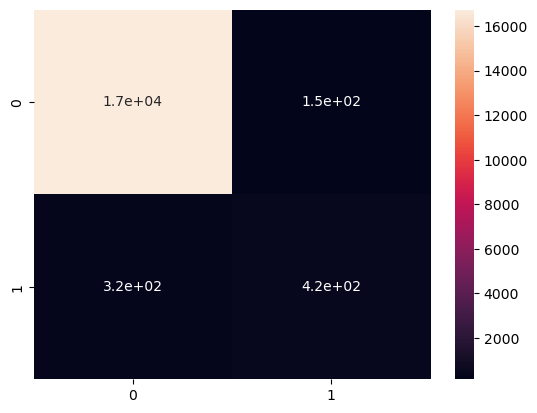

Mean Squared Error: 0.026656079854809438


In [48]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error

# For Classification
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

# For Regression
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

C:\Users\juna7\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\juna7\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\juna7\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


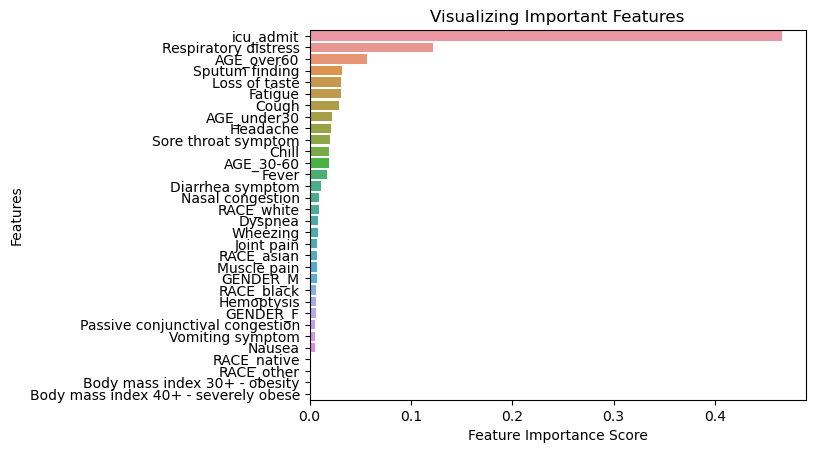

In [49]:
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()